### 패키지 선언

In [ ]:
import torch
import torch.nn as nn
import torchvision.datasets as dataset
import torchvision.transforms as transform
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

## Dataset 다운로드

In [ ]:
# Training dataset 다운로드
cifar10_train = dataset.CIFAR10(root = "./",
                            train = True,
                            transform = transform.ToTensor(),
                            download = True)
# Testing dataset 다운로드
cifar10_test = dataset.CIFAR10(root = "./",
                            train = False,
                            transform = transform.ToTensor(),
                            download = True)

dataLabel = ["airplane","automobile","bird","cat","deer","dog","frog","horse","ship","truck"]

100%|██████████| 170498071/170498071 [00:03<00:00, 50114307.29it/s]


Extracting ./cifar-10-python.tar.gz to ./
Files already downloaded and verified


## 신경망 모델 정의
- Fully Connected Layer -> nn.Linear(in_features, out_features)
- Convolutional Layer -> nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
- ReLU -> nn.ReLU()
- Max Pooling -> nn.MaxPool2d(kernel_size, stride)


In [ ]:
class SimplifiedVGG(nn.Module):

  def __init__(self):
    super(SimplifiedVGG, self).__init__()

    # 신경망 파라미터 초기화 (Conv 6개, FC 3개, ReLU, MaxPool)
    self.conv1_1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)    # Convolution: [3x3x3]x16, s1, p1
    self.conv1_2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)   # Convolution: [3x3x16]x32, s1, p1

    self.conv2_1 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1)   # Convolution: [3x3x32]x32, s1, p1
    self.conv2_2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)   # Convolution: [3x3x32]x64, s1, p1

    self.conv3_1 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)  # Convolution: [3x3x64]x128, s1, p1
    self.conv3_2 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1) # Convolution: [3x3x128]x256, s1, p1

    self.fc1 = nn.Linear(in_features=4096, out_features=512)
    self.fc2 = nn.Linear(in_features=512, out_features=256)
    self.fc3 = nn.Linear(in_features=256, out_features=10)

    self.relu = nn.ReLU()
    self.max_pool = nn.MaxPool2d(kernel_size=2, stride=2)

  def forward(self, x):
    #-----------------------------------------------------------------
    # Convolution, ReLU, MaxPool layer
    y = self.relu(self.conv1_1(x))
    y = self.relu(self.conv1_2(y))
    y = self.max_pool(y)

    y = self.relu(self.conv2_1(y))
    y = self.relu(self.conv2_2(y))
    y = self.max_pool(y)

    y = self.relu(self.conv3_1(y))
    y = self.relu(self.conv3_2(y))
    y = self.max_pool(y)
    #-----------------------------------------------------------------

    y = y.view(-1, 4096) # feature map 평탄화

    #-----------------------------------------------------------------
    # Fully Connected, ReLU layer
    y = self.relu(self.fc1(y))
    y = self.relu(self.fc2(y))
    y = self.fc3(y)
    #-----------------------------------------------------------------

    return y


In [ ]:
class SimplifiedVGG_skip(nn.Module):

  def __init__(self):
    super(SimplifiedVGG_skip, self).__init__()

    # 신경망 파라미터 초기화 (Conv 6개, FC 3개, ReLU, MaxPool)
    self.conv1_1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)    # Convolution: [3x3x3]x16, s1, p1
    self.conv1_2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)   # Convolution: [3x3x16]x32, s1, p1

    self.conv2_1 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1)   # Convolution: [3x3x32]x32, s1, p1
    self.conv2_2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)   # Convolution: [3x3x32]x64, s1, p1

    self.conv3_1 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)  # Convolution: [3x3x64]x128, s1, p1
    self.conv3_2 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1) # Convolution: [3x3x128]x256, s1, p1

    self.fc1 = nn.Linear(in_features=4096, out_features=512)
    self.fc2 = nn.Linear(in_features=512, out_features=256)
    self.fc3 = nn.Linear(in_features=256, out_features=10)

    self.relu = nn.ReLU()
    self.max_pool = nn.MaxPool2d(kernel_size=2, stride=2)

    self.conv_skip1 =  nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)
    self.conv_skip2 =  nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
    self.conv_skip3 =  nn.Conv2d(in_channels=64, out_channels=256, kernel_size=3, stride=1, padding=1)


  def forward(self, x):
    #-----------------------------------------------------------------
    # Convolution, ReLU, MaxPool layer
    skip_y = self.conv_skip1(x)
    y = self.relu(self.conv1_1(x))
    y = self.relu(self.conv1_2(y))
    y = y + skip_y
    y = self.max_pool(y)

    skip_y = self.conv_skip2(y)
    y = self.relu(self.conv2_1(y))
    y = self.relu(self.conv2_2(y))
    y = y + skip_y
    y = self.max_pool(y)

    skip_y = self.conv_skip3(y)
    y = self.relu(self.conv3_1(y))
    y = self.relu(self.conv3_2(y))
    y = y + skip_y
    y = self.max_pool(y)
    #-----------------------------------------------------------------

    y = y.view(-1, 4096) # feature map 평탄화

    #-----------------------------------------------------------------
    # Fully Connected, ReLU layer
    y = self.relu(self.fc1(y))
    y = self.relu(self.fc2(y))
    y = self.fc3(y)
    #-----------------------------------------------------------------

    return y

In [ ]:
class SimplifiedVGG_dense(nn.Module):

  def __init__(self):
    super(SimplifiedVGG_dense, self).__init__()

    # 신경망 파라미터 초기화 (Conv 6개, FC 3개, ReLU, MaxPool)
    self.conv1_1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)    # Convolution: [3x3x3]x16, s1, p1
    self.conv1_2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)   # Convolution: [3x3x16]x32, s1, p1

    self.conv2_1 = nn.Conv2d(in_channels=35, out_channels=32, kernel_size=3, stride=1, padding=1)   # Convolution: [3x3x32]x32, s1, p1
    self.conv2_2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)   # Convolution: [3x3x32]x64, s1, p1

    self.conv3_1 = nn.Conv2d(in_channels=99, out_channels=128, kernel_size=3, stride=1, padding=1)  # Convolution: [3x3x64]x128, s1, p1
    self.conv3_2 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1) # Convolution: [3x3x128]x256, s1, p1

    self.fc1 = nn.Linear(in_features=4096, out_features=512)
    self.fc2 = nn.Linear(in_features=512, out_features=256)
    self.fc3 = nn.Linear(in_features=256, out_features=10)

    self.relu = nn.ReLU()
    self.max_pool = nn.MaxPool2d(kernel_size=2, stride=2)

  def forward(self, x):
    #-----------------------------------------------------------------
    # Convolution, ReLU, MaxPool layer
    dense_y = x
    y = self.relu(self.conv1_1(x))
    y = self.relu(self.conv1_2(y))
    y = torch.cat([y, dense_y], dim = 1)
    y = self.max_pool(y)

    dense_y = y
    y = self.relu(self.conv2_1(y))
    y = self.relu(self.conv2_2(y))
    y = torch.cat([y, dense_y], dim = 1)
    y = self.max_pool(y)

    y = self.relu(self.conv3_1(y))
    y = self.relu(self.conv3_2(y))
    y = self.max_pool(y)
    #-----------------------------------------------------------------

    y = y.view(-1, 4096) # feature map 평탄화

    #-----------------------------------------------------------------
    # Fully Connected, ReLU layer
    y = self.relu(self.fc1(y))
    y = self.relu(self.fc2(y))
    y = self.fc3(y)
    #-----------------------------------------------------------------

    return y

In [ ]:
class ChannelAttention(nn.Module):
  def __init__(self, channels, reduction):
    super(ChannelAttention, self).__init__()
    self.gap = nn.AdaptiveAvgPool2d((1, 1))
    self.conv1 = nn.Conv2d(channels, channels//reduction, 1)
    self.conv2 = nn.Conv2d(channels//reduction, channels, 1)
    self.relu = nn.ReLU()
    self.sigmoid = nn.Sigmoid()

  def forward(self, x):
    ca_out = self.gap(x)
    ca_out = self.relu(self.conv1(ca_out))
    ca_out = self.sigmoid(self.conv2(ca_out))
    ca_out = ca_out.expand_as(x)
    y = x * ca_out

    return y
class SimplifiedVGG_CA(nn.Module):

  def __init__(self):
    super(SimplifiedVGG_CA, self).__init__()

    # 신경망 파라미터 초기화 (Conv 6개, FC 3개, ReLU, MaxPool)
    self.conv1_1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)    # Convolution: [3x3x3]x16, s1, p1
    self.conv1_2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)   # Convolution: [3x3x16]x32, s1, p1

    self.conv2_1 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1)   # Convolution: [3x3x32]x32, s1, p1
    self.conv2_2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)   # Convolution: [3x3x32]x64, s1, p1

    self.conv3_1 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)  # Convolution: [3x3x64]x128, s1, p1
    self.conv3_2 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1) # Convolution: [3x3x128]x256, s1, p1

    self.fc1 = nn.Linear(in_features=4096, out_features=512)
    self.fc2 = nn.Linear(in_features=512, out_features=256)
    self.fc3 = nn.Linear(in_features=256, out_features=10)

    self.relu = nn.ReLU()
    self.max_pool = nn.MaxPool2d(kernel_size=2, stride=2)

    self.channel_attention = ChannelAttention(channels = 64, reduction = 1)

  def forward(self, x):
    #-----------------------------------------------------------------
    # Convolution, ReLU, MaxPool layer
    y = self.relu(self.conv1_1(x))
    y = self.relu(self.conv1_2(y))
    y = self.max_pool(y)

    y = self.relu(self.conv2_1(y))
    y = self.relu(self.conv2_2(y))
    y = self.channel_attention(y)
    y = self.max_pool(y)

    y = self.relu(self.conv3_1(y))
    y = self.relu(self.conv3_2(y))
    y = self.max_pool(y)
    #-----------------------------------------------------------------

    y = y.view(-1, 4096) # feature map 평탄화

    #-----------------------------------------------------------------
    # Fully Connected, ReLU layer
    y = self.relu(self.fc1(y))
    y = self.relu(self.fc2(y))
    y = self.fc3(y)
    #-----------------------------------------------------------------

    return y


## Hyper-parameters 지정

In [ ]:
batch_size = 100
learning_rate = 0.1
training_epochs = 15
loss_function = nn.CrossEntropyLoss()
network = SimplifiedVGG_CA().to('cuda')
optimizer = torch.optim.SGD(network.parameters(), lr = learning_rate)

data_loader = DataLoader(dataset=cifar10_train,
                         batch_size=batch_size,
                         shuffle=True,
                         drop_last=True)

## CNN 학습을 위한 반복문 선언

In [ ]:
for epoch in range(training_epochs):
  network.train()
  avg_cost = 0
  total_batch = len(data_loader)

  for img, label in data_loader:
    img = img.to('cuda')
    label = label.to('cuda')
    pred = network(img)

    loss = loss_function(pred, label)
    optimizer.zero_grad() # gradient 초기화
    loss.backward()
    optimizer.step()

    avg_cost += loss / total_batch

  print('Epoch: %d Loss = %f'%(epoch+1, avg_cost))

print('Learning finished')

Epoch: 1 Loss = 2.303004
Epoch: 2 Loss = 2.302912
Epoch: 3 Loss = 2.302861
Epoch: 4 Loss = 2.302648
Epoch: 5 Loss = 2.226294
Epoch: 6 Loss = 1.979206
Epoch: 7 Loss = 1.793637
Epoch: 8 Loss = 1.679631
Epoch: 9 Loss = 1.518262
Epoch: 10 Loss = 1.324152
Epoch: 11 Loss = 1.183208
Epoch: 12 Loss = 1.050427
Epoch: 13 Loss = 0.926121
Epoch: 14 Loss = 0.790353
Epoch: 15 Loss = 0.651629
Learning finished


## 학습이 완료된 모델을 이용해 정답률 확인

In [ ]:
network.eval()
network = network.to('cpu')
img_test = torch.tensor(np.transpose(cifar10_test.data,(0,3,1,2))) / 255.
label_test = torch.tensor(cifar10_test.targets)

with torch.no_grad(): # test에서는 기울기 계산 제외
  prediction = network(img_test) # 전체 test data를 한번에 계산

  correct_prediction = torch.argmax(prediction, 1) == label_test
  accuracy = correct_prediction.float().mean()
  print('Accuracy:', accuracy.item())

Accuracy: 0.6319000124931335


## 예측 결과 확인

tensor([[ 3.2422,  5.4999, -1.8168, -2.7026, -2.9295, -2.2970, -3.8777, -2.3914,
          0.9858,  9.9425]])
prediction:  truck
label:  truck


<function matplotlib.pyplot.show(close=None, block=None)>

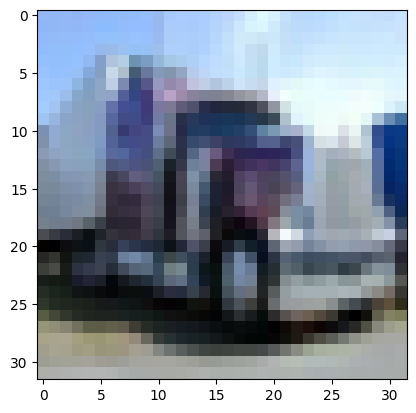

In [ ]:
dataIdx = 2020
tmp_img = img_test[dataIdx].unsqueeze(0)
tmp_label = label_test[dataIdx]

with torch.no_grad():
  prediction = network(tmp_img)
tmp_img = tmp_img.squeeze(0)
prediction_num = torch.argmax(prediction, 1)

print(prediction)
print("prediction: ", dataLabel[prediction_num])
print("label: ", dataLabel[tmp_label])

plt.imshow(np.transpose(tmp_img,(1,2,0)))
plt.show

In [ ]:
from torchsummary import summary
summary(SimplifiedVGG_skip().to('cuda'), (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
            Conv2d-2           [-1, 16, 32, 32]             448
              ReLU-3           [-1, 16, 32, 32]               0
            Conv2d-4           [-1, 32, 32, 32]           4,640
              ReLU-5           [-1, 32, 32, 32]               0
         MaxPool2d-6           [-1, 32, 16, 16]               0
            Conv2d-7           [-1, 64, 16, 16]          18,496
            Conv2d-8           [-1, 32, 16, 16]           9,248
              ReLU-9           [-1, 32, 16, 16]               0
           Conv2d-10           [-1, 64, 16, 16]          18,496
             ReLU-11           [-1, 64, 16, 16]               0
        MaxPool2d-12             [-1, 64, 8, 8]               0
           Conv2d-13            [-1, 256, 8, 8]         147,712
           Conv2d-14            [-1, 12